In [54]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix
import itertools

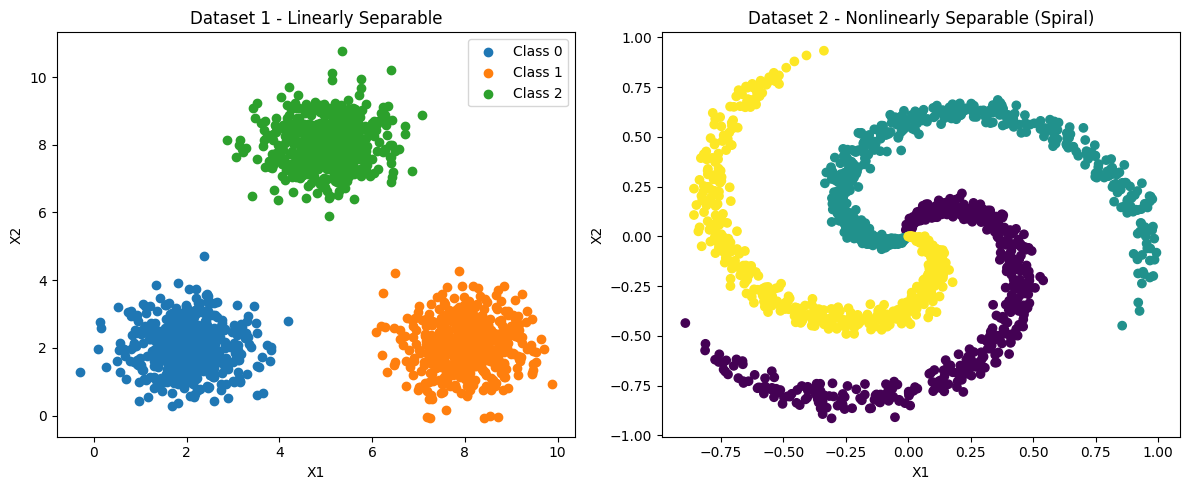

Dataset1 shape: (1500, 3)
Dataset2 shape: (1500, 3)
Files saved as dataset1.txt and dataset2.txt


In [62]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# ==========================
# DATASET 1: LINEAR (3 CLASS)
# ==========================
n = 500

mean0 = [2, 2]
cov0 = [[0.5, 0], [0, 0.5]]
class0 = np.random.multivariate_normal(mean0, cov0, n)
labels0 = np.zeros(n)

mean1 = [8, 2]
cov1 = [[0.5, 0], [0, 0.5]]
class1 = np.random.multivariate_normal(mean1, cov1, n)
labels1 = np.ones(n)

mean2 = [5, 8]
cov2 = [[0.5, 0], [0, 0.5]]
class2 = np.random.multivariate_normal(mean2, cov2, n)
labels2 = np.full(n, 2)

X1 = np.vstack((class0, class1, class2))
y1 = np.concatenate((labels0, labels1, labels2)).astype(int)

dataset1 = np.column_stack((X1, y1))
np.savetxt("dataset1.txt", dataset1, fmt="%.5f")


# ==========================
# DATASET 2: SPIRAL (3 CLASS)
# ==========================
n = 500
K = 3

X2 = np.zeros((n*K, 2))
y2 = np.zeros(n*K, dtype=int)

for j in range(K):
    ix = range(n*j, n*(j+1))

    r = np.linspace(0.0, 1, n)
    t = np.linspace(j*4, (j+1)*4, n)
    t += np.random.randn(n) * 0.15   # slightly smoother than 0.2

    X2[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y2[ix] = j

dataset2 = np.column_stack((X2, y2))
np.savetxt("dataset2.txt", dataset2, fmt="%.5f")


# ==========================
# PLOT BOTH SIDE BY SIDE
# ==========================
plt.figure(figsize=(12,5))

# ---- Dataset 1 ----
plt.subplot(1,2,1)
for c in np.unique(y1):
    plt.scatter(X1[y1==c,0],
                X1[y1==c,1],
                label=f"Class {c}")
plt.title("Dataset 1 - Linearly Separable")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()

# ---- Dataset 2 ----
plt.subplot(1,2,2)
plt.scatter(X2[:,0], X2[:,1], c=y2)
plt.title("Dataset 2 - Nonlinearly Separable (Spiral)")
plt.xlabel("X1")
plt.ylabel("X2")

plt.tight_layout()
plt.show()


print("Dataset1 shape:", dataset1.shape)
print("Dataset2 shape:", dataset2.shape)
print("Files saved as dataset1.txt and dataset2.txt")

In [56]:
data1 = np.loadtxt("dataset1.txt")
X1 = data1[:, :2]
y1 = data1[:, 2].astype(int)

data2 = np.loadtxt("dataset2.txt")
X2 = data2[:, :2]
y2 = data2[:, 2].astype(int)

def split_per_class(X, y):
    classes = np.unique(y)

    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []

    for c in classes:
        idx = np.where(y == c)[0]
        np.random.shuffle(idx)

        n = len(idx)
        n_train = int(0.6*n)
        n_val = int(0.2*n)

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train+n_val]
        test_idx = idx[n_train+n_val:]

        X_train.append(X[train_idx])
        X_val.append(X[val_idx])
        X_test.append(X[test_idx])

        y_train.append(y[train_idx])
        y_val.append(y[val_idx])
        y_test.append(y[test_idx])

    return (np.vstack(X_train), np.concatenate(y_train),
            np.vstack(X_val), np.concatenate(y_val),
            np.vstack(X_test), np.concatenate(y_test))


X1_train, y1_train, X1_val, y1_val, X1_test, y1_test = split_per_class(X1, y1)
X2_train, y2_train, X2_val, y2_val, X2_test, y2_test = split_per_class(X2, y2)

def one_hot(y, num_classes):
    oh = np.zeros((len(y), num_classes))
    oh[np.arange(len(y)), y] = 1
    return oh

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def confusion_matrix_manual(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes))
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1
    return cm
class FCNN:
    def __init__(self, input_dim, hidden_layers, output_dim, lr=0.05):
        self.lr = lr
        self.layers = []
        dims = [input_dim] + hidden_layers + [output_dim]

        for i in range(len(dims)-1):
            W = np.random.randn(dims[i], dims[i+1]) * np.sqrt(2/dims[i])
            b = np.zeros((1, dims[i+1]))
            self.layers.append({'W': W, 'b': b})

    # -------- Activations --------
    def tanh(self, x):
        return np.tanh(x)

    def tanh_deriv(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # -------- Forward --------
    def forward(self, X):
        self.cache = []
        A = X

        for i, layer in enumerate(self.layers):
            Z = A @ layer['W'] + layer['b']

            if i < len(self.layers)-1:
                A = self.tanh(Z)
            else:
                A = self.softmax(Z)

            self.cache.append((A, Z))

        return A

    # -------- Backward --------
    def backward(self, X, y):
        m = len(X)
        dA = self.cache[-1][0] - y   # softmax + crossentropy simplification

        for i in reversed(range(len(self.layers))):
            A_prev = X if i == 0 else self.cache[i-1][0]
            A_curr, Z_curr = self.cache[i]

            if i < len(self.layers)-1:
                dZ = dA * self.tanh_deriv(Z_curr)
            else:
                dZ = dA

            dW = A_prev.T @ dZ / m
            db = np.sum(dZ, axis=0, keepdims=True) / m
            dA = dZ @ self.layers[i]['W'].T

            self.layers[i]['W'] -= self.lr * dW
            self.layers[i]['b'] -= self.lr * db

    # -------- Train (Mini-Batch) --------
    def train(self, X, y, epochs=300, batch_size=32):
        n = len(X)
        losses = []

        for ep in range(epochs):
            indices = np.random.permutation(n)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(0, n, batch_size):
                xi = X_shuffled[i:i+batch_size]
                yi = y_shuffled[i:i+batch_size]

                self.forward(xi)
                self.backward(xi, yi)

            # compute loss (cross entropy)
            out = self.forward(X)
            loss = -np.mean(np.sum(y * np.log(out + 1e-8), axis=1))
            losses.append(loss)

        return losses

    def predict(self, X):
        out = self.forward(X)
        return np.argmax(out, axis=1)

In [57]:
hidden_options1 = [[3], [5], [8]]
best_acc1 = 0
best_model1 = None
best_hidden1 = None

for hidden in hidden_options1:

    model = FCNN(2, hidden, 3, lr=0.03)   # slightly better lr
    model.train(X1_train, one_hot(y1_train,3), epochs=300)

    val_pred = model.predict(X1_val)
    acc = accuracy(y1_val, val_pred)

    print("Hidden:", hidden)
    print("Validation Accuracy:", acc)
    print("Unique Predictions:", np.unique(val_pred))
    print("------------------------")

    if acc > best_acc1:
        best_acc1 = acc
        best_model1 = model
        best_hidden1 = hidden

print("Best Architecture Dataset1:", best_hidden1)
print("Best Validation Accuracy:", best_acc1)

Hidden: [3]
Validation Accuracy: 0.84
Unique Predictions: [0 1 2]
------------------------
Hidden: [5]
Validation Accuracy: 1.0
Unique Predictions: [0 1 2]
------------------------
Hidden: [8]
Validation Accuracy: 1.0
Unique Predictions: [0 1 2]
------------------------
Best Architecture Dataset1: [5]
Best Validation Accuracy: 1.0


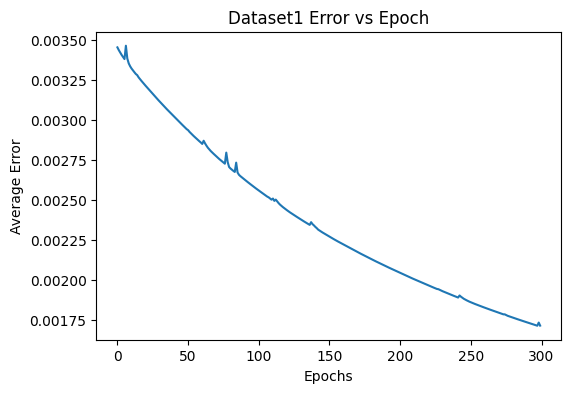

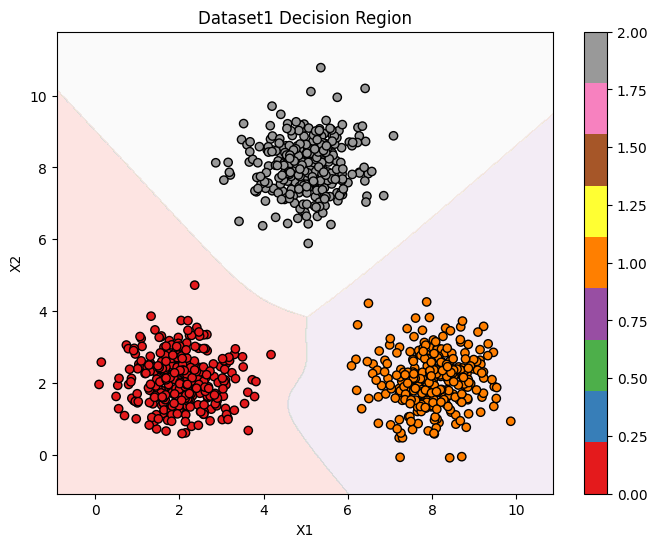

Test Accuracy Dataset1: 1.0
Confusion Matrix:
[[100.   0.   0.]
 [  0. 100.   0.]
 [  0.   0. 100.]]


In [58]:
# ---- Plot Error (Retrain once properly if needed) ----
errors1 = best_model1.train(X1_train, one_hot(y1_train,3), epochs=300)

plt.figure(figsize=(6,4))
plt.plot(errors1)
plt.xlabel("Epochs")
plt.ylabel("Average Error")
plt.title("Dataset1 Error vs Epoch")
plt.show()


# ---- Decision Region ----
def plot_decision_region(model, X, y, title="Decision Boundary"):

    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 500),
        np.linspace(y_min, y_max, 500)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.35, cmap=plt.cm.Pastel1)

    scatter = plt.scatter(
        X[:,0], X[:,1],
        c=y,
        cmap=plt.cm.Set1,
        edgecolor='k'
    )

    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.colorbar(scatter)
    plt.show()


plot_decision_region(best_model1, X1_train, y1_train,
                     "Dataset1 Decision Region")


# ---- Test Evaluation ----
test_pred1 = best_model1.predict(X1_test)

print("Test Accuracy Dataset1:", accuracy(y1_test, test_pred1))
print("Confusion Matrix:")
print(confusion_matrix_manual(y1_test, test_pred1, 3))

Hidden: [8, 8]
Validation Accuracy: 0.9966666666666667
Unique Predictions: [0 1 2]
------------------------
Hidden: [12, 10]
Validation Accuracy: 0.9966666666666667
Unique Predictions: [0 1 2]
------------------------
Hidden: [15, 12]
Validation Accuracy: 0.9766666666666667
Unique Predictions: [0 1 2]
------------------------
Best Architecture Dataset2: [8, 8]
Best Validation Accuracy: 0.9966666666666667


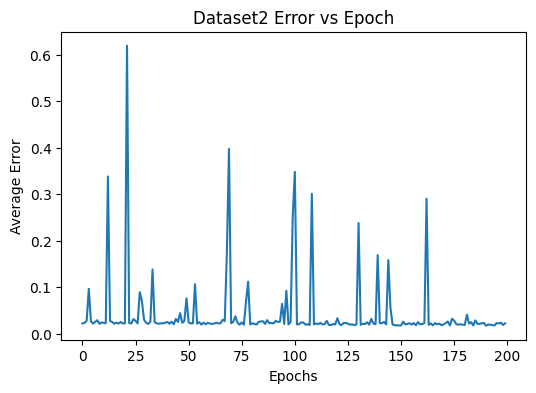

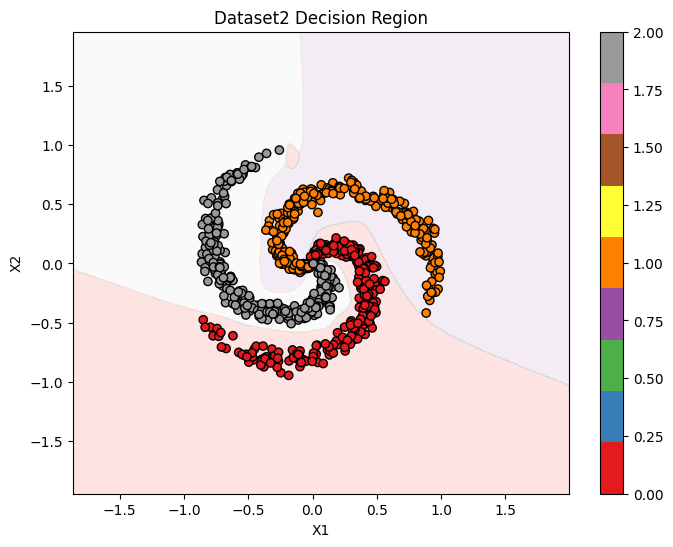

Test Accuracy Dataset2: 0.9933333333333333
Confusion Matrix:
[[ 99.   0.   1.]
 [  0. 100.   0.]
 [  1.   0.  99.]]


In [59]:
hidden_options2 = [[8,8], [12,10], [15,12]]
best_acc2 = 0
best_model2 = None
best_hidden2 = None

for hidden in hidden_options2:

    model = FCNN(2, hidden, 3, lr=0.05)   # stronger lr
    model.train(X2_train, one_hot(y2_train,3), epochs=600)

    val_pred = model.predict(X2_val)
    acc = accuracy(y2_val, val_pred)

    print("Hidden:", hidden)
    print("Validation Accuracy:", acc)
    print("Unique Predictions:", np.unique(val_pred))
    print("------------------------")

    if acc > best_acc2:
        best_acc2 = acc
        best_model2 = model
        best_hidden2 = hidden

print("Best Architecture Dataset2:", best_hidden2)
print("Best Validation Accuracy:", best_acc2)


# ---- Plot Error (DO NOT retrain again heavily) ----
errors2 = best_model2.train(X2_train, one_hot(y2_train,3), epochs=200)

plt.figure(figsize=(6,4))
plt.plot(errors2)
plt.xlabel("Epochs")
plt.ylabel("Average Error")
plt.title("Dataset2 Error vs Epoch")
plt.show()


# ---- Decision Region ----
plot_decision_region(best_model2, X2_train, y2_train,
                     "Dataset2 Decision Region")


# ---- Test Evaluation ----
test_pred2 = best_model2.predict(X2_test)

print("Test Accuracy Dataset2:", accuracy(y2_test, test_pred2))
print("Confusion Matrix:")
print(confusion_matrix_manual(y2_test, test_pred2, 3))

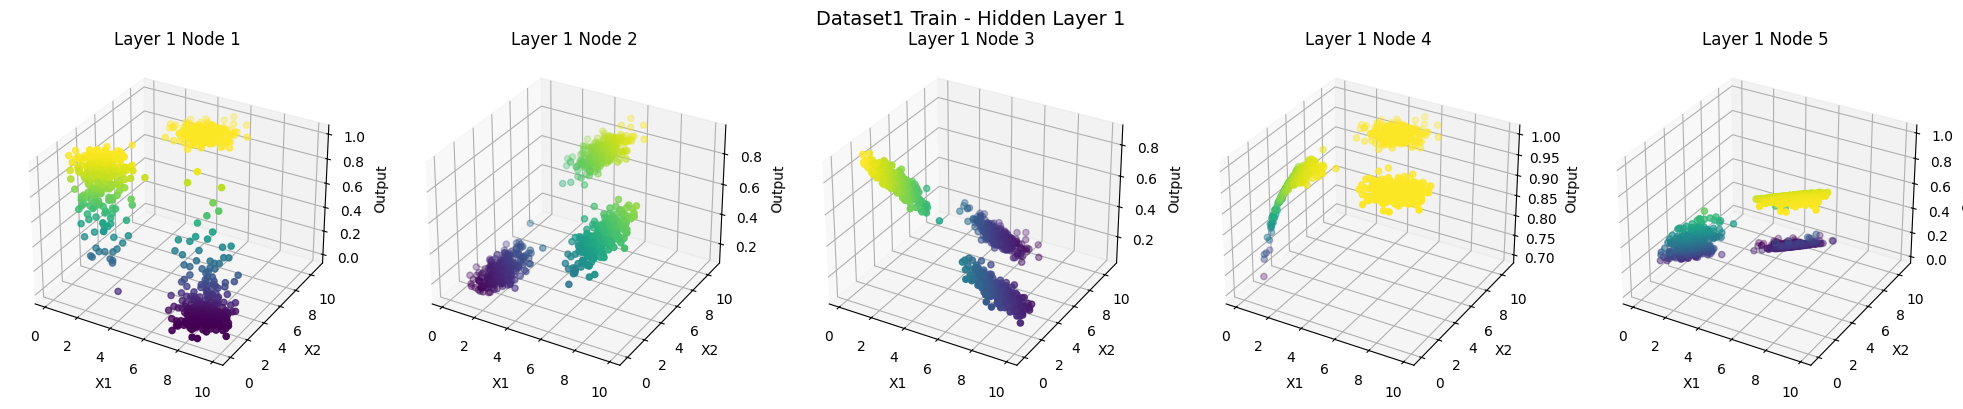

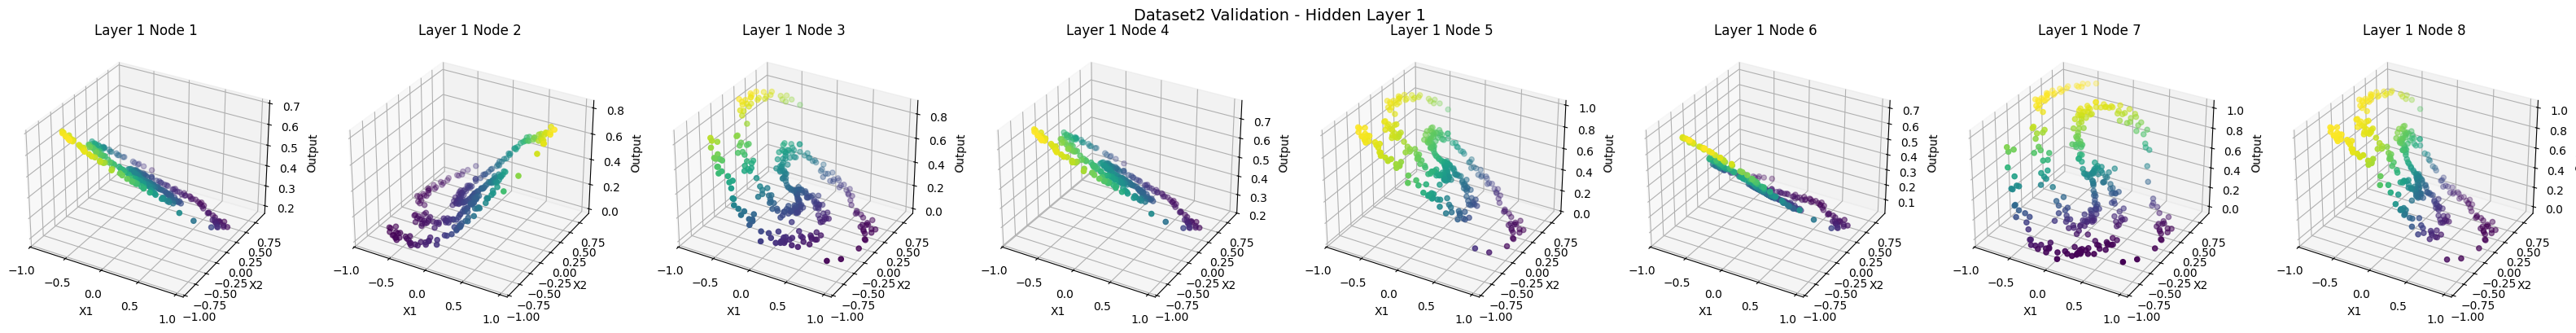

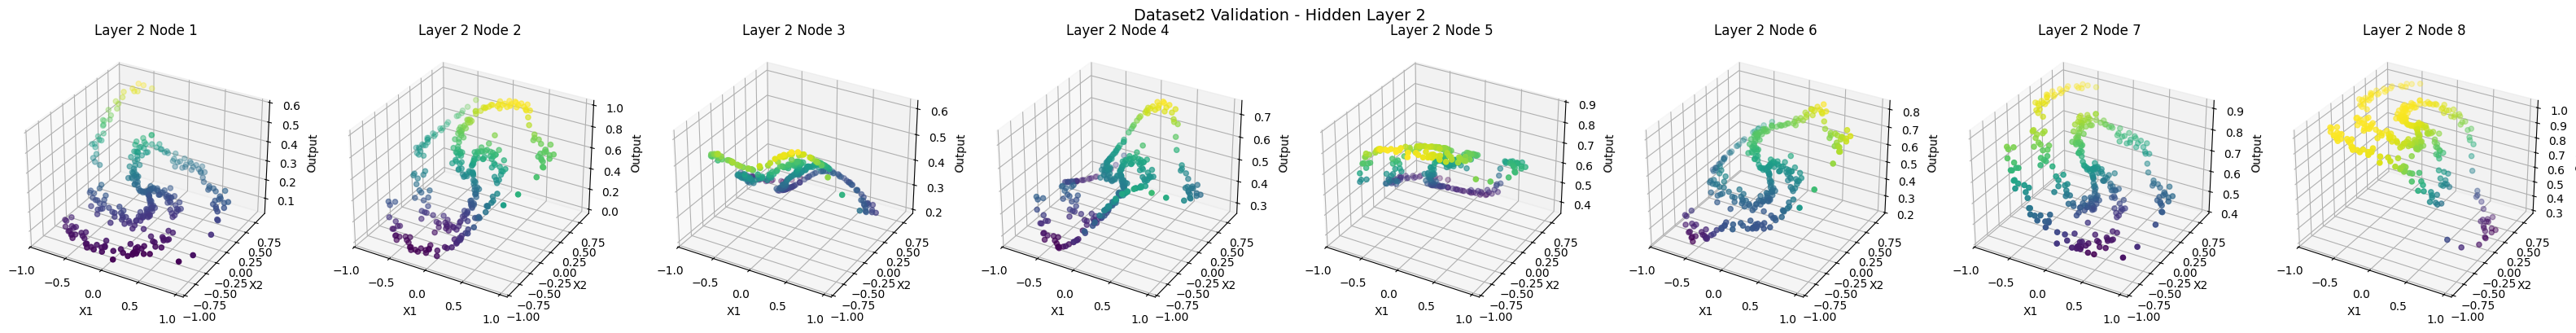

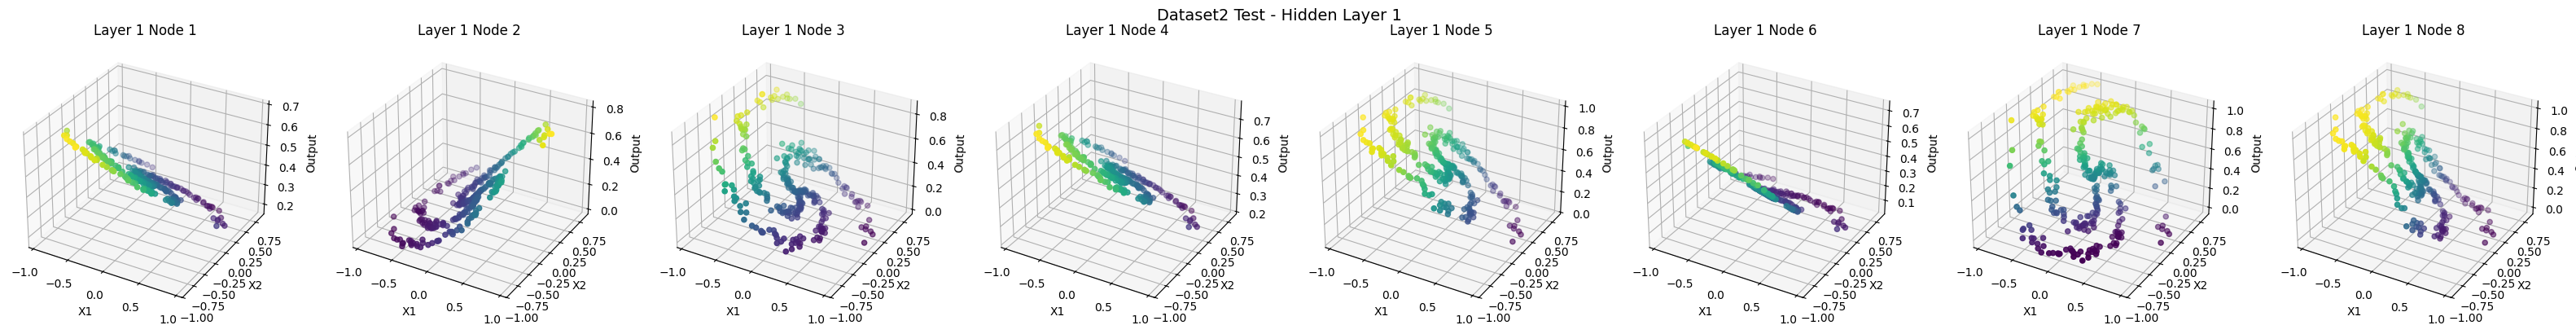

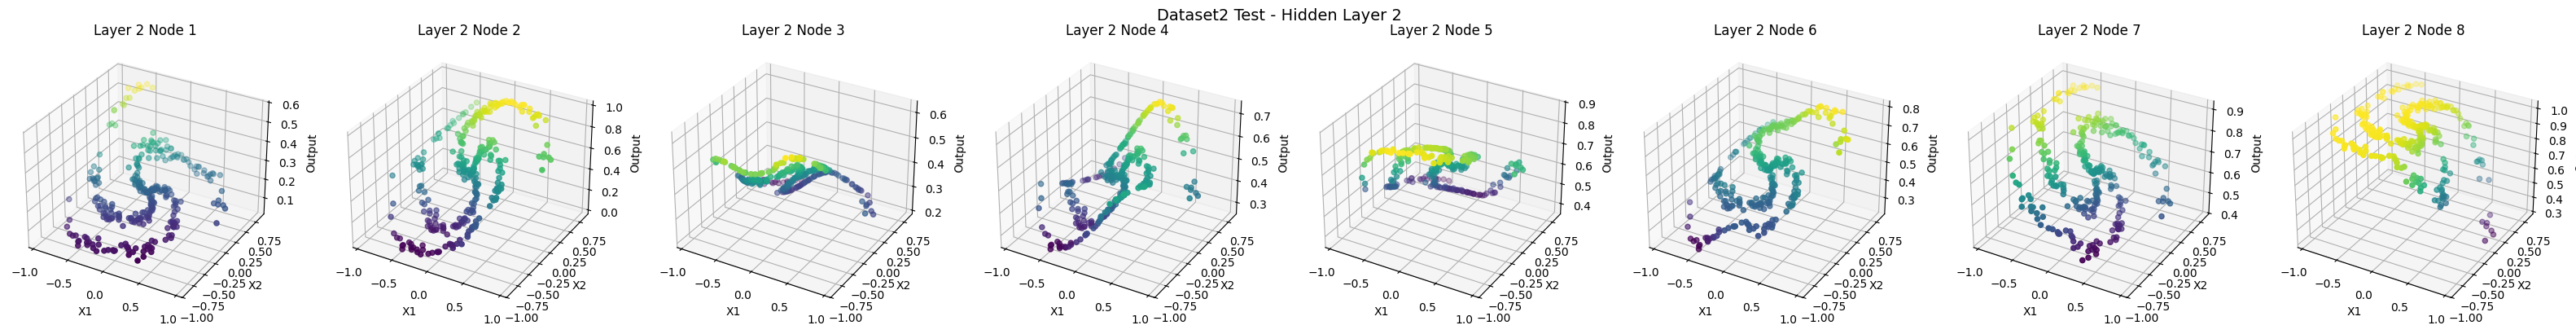

In [61]:
# -------- Forward pass to get activations --------
def forward_hidden_only(model, X):
    activations = []
    A = X
    for i, layer in enumerate(model.layers):
        Z = A @ layer['W'] + layer['b']
        A = 1 / (1 + np.exp(-Z))  # sigmoid

        # Store only hidden layers (exclude final output layer)
        if i < len(model.layers) - 1:
            activations.append(A)

    return activations


# -------- Plot hidden layers side by side --------
def plot_hidden_layers_side_by_side(model, X, dataset_name="Dataset"):

    hidden_activations = forward_hidden_only(model, X)

    for layer_index, layer_output in enumerate(hidden_activations):

        num_nodes = layer_output.shape[1]
        fig = plt.figure(figsize=(4*num_nodes, 4))

        for node in range(num_nodes):
            ax = fig.add_subplot(1, num_nodes, node+1, projection='3d')

            ax.scatter(
                X[:,0],
                X[:,1],
                layer_output[:,node],
                c=layer_output[:,node],
                cmap='viridis'
            )

            ax.set_xlabel("X1")
            ax.set_ylabel("X2")
            ax.set_zlabel("Output")
            ax.set_title(f"Layer {layer_index+1} Node {node+1}")

        fig.suptitle(f"{dataset_name} - Hidden Layer {layer_index+1}", fontsize=14)
        plt.tight_layout()
        plt.show()


# ==========================
# DATASET 1 (BEST MODEL)
# ==========================

plot_hidden_layers_side_by_side(best_model1, X1_train, "Dataset1 Train")
plot_hidden_layers_side_by_side(best_model1, X1_val,   "Dataset1 Validation")
plot_hidden_layers_side_by_side(best_model1, X1_test,  "Dataset1 Test")


# ==========================
# DATASET 2 (BEST MODEL)
# ==========================

plot_hidden_layers_side_by_side(best_model2, X2_train, "Dataset2 Train")
plot_hidden_layers_side_by_side(best_model2, X2_val,   "Dataset2 Validation")
plot_hidden_layers_side_by_side(best_model2, X2_test,  "Dataset2 Test")